# Project Dataset Loading

In [ ]:
import zipfile
import os
import numpy as np
import xml.etree.ElementTree as ET
import glob
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Clone the dataset repository from github
!git clone https://github.com/CodyRichter/Automatic-Short-Answer-Grading

Cloning into 'Automatic-Short-Answer-Grading'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 33 (delta 12), reused 23 (delta 8), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [ ]:
import json

with open('/content/Automatic-Short-Answer-Grading/dataset/train.json', 'r') as tf:
  training_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-answers.json', 'r') as tf:
  test_unseen_answer_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-questions.json', 'r') as tf:
  test_unseen_question_data = json.load(tf)

with open('/content/Automatic-Short-Answer-Grading/dataset/test-unseen-domains.json', 'r') as tf:
  test_unseen_domain_data = json.load(tf)

print('Number of Training + Validation Data Responses', len(training_data))

Number of Training + Validation Data Responses 16265


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ShortAnswerGradingDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Note: I handle the parsing in the data loading from XML section
        # Returns a dict for each item with the following keys: 'question', 'ref', 'response', 'score' all of type 'str'
        return self.dataset[idx]

In [ ]:
training_dataset = ShortAnswerGradingDataset(training_data)
test_dataset_unseen_answers = ShortAnswerGradingDataset(test_unseen_answer_data)
test_dataset_unseen_questions = ShortAnswerGradingDataset(test_unseen_question_data)
test_dataset_unseen_domains = ShortAnswerGradingDataset(test_unseen_domain_data)

from sklearn.model_selection import train_test_split

training_dataset, validation_dataset = train_test_split(training_dataset, test_size=0.1, random_state=0)

validation_parent_ids = set()
validation_ids_to_remove = set()
validation_original_ids = set()

# Step 1: Get IDs of Original Responses and mark augmented ones for deletion
for validation_item in validation_dataset:
  if validation_item['aug']:
    validation_parent_ids.add(validation_item['aug_metadata']['parent_id'])
    validation_ids_to_remove.add(validation_item['id'])
  else:
    validation_original_ids.add(validation_item['id'])

train_ids_to_remove = set()

# Step 2: Obtain Original Respones for validation set and mark augmented
#         dataset items for removal if the original is in the validation set
for train_item in training_dataset:

  # If the original is in the validation set, remove from the training set
  if train_item['aug'] and train_item['aug_metadata']['parent_id'] in validation_original_ids:
    train_ids_to_remove.add(train_item['id'])

  # If the original is in the training set, add it to the validation set
  # and then mark it for deletion from the training set
  if not train_item['aug'] and train_item['id'] in validation_parent_ids:
    validation_dataset.append(train_item)
    train_ids_to_remove.add(train_item['id'])

# Step 3: Perform removal operations
validation_dataset[:] = [x for x in validation_dataset if x['id'] not in validation_ids_to_remove]
training_dataset[:] = [x for x in training_dataset if x['id'] not in train_ids_to_remove]

In [ ]:
print('Number of Training Samples', len(training_dataset))
print('Number of Validation Samples', len(validation_dataset))
print('Number of Test Data (New Answer) Responses', len(test_unseen_answer_data))
print('Number of Test Data (New Question) Responses', len(test_unseen_question_data))
print('Number of Test Data (New Domain) Responses', len(test_unseen_domain_data))

Number of Training Samples 12805
Number of Validation Samples 1380
Number of Test Data (New Answer) Responses 540
Number of Test Data (New Question) Responses 733
Number of Test Data (New Domain) Responses 4562


In [ ]:
training_data = training_dataset
test_data = test_unseen_question_data

## Batching and Loading Data to Model

Use this iterator to load in the train and test datasets to the model of choice.

In [ ]:
#Set up training_data & test_data
print(training_data[0])
print(len(training_data))
print(len(test_data))

{'question': "Pam and her family were planning a hike. Pam found 2 maps of the same area. Her friend recommended she use the topographic map when they went to the lake. Why would Pam's friend recommend using the topographic map for the hike?", 'ref': 'She recommended the topographic map because the map shows the elevations along the trail. Pam would know where the trail was the steepest.', 'response': 'Because both maps show the shapes of landforms, but a topographic map shows elevation and dip.', 'score': 'incorrect', 'aug': True, 'id': 18221, 'aug_metadata': {'parent_id': 3816, 'translation_seq': ['en', 'es', 'en']}}
12805
733


## Installation
---

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 18.1 MB/s 
     |████████████████████████████████| 1.2 MB 49.5 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 54.2 MB/s 
     |████████████████████████████████| 880 kB 56.0 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=84b61fc5997616e7d36234ce57127dad11f6705bf112d23370ff46706e888670
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=4fbf593d6e0566a6ec4da5f1e4d2526e3d00f67f32f6d8767f19fe23dc156e5c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sa

In [ ]:
from sentence_transformers import SentenceTransformer, util
# model = SentenceTransformer('all-MiniLM-L6-v2')
# Same model as the BERT_baseline approach
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Create inputs for similarity check
---

In [ ]:
# Concate the reference answer and student answer to creat new input for both train and test set
train_data_response = []
train_data_ref = []
train_data_score = []
test_data_response = []
test_data_ref = []
test_data_score = []

for training_item in training_data:
  train_data_response.append(training_item["response"])
  train_data_ref.append(training_item["ref"])
  train_data_score.append(training_item["score"])


for test_item in test_data:
  test_data_response.append(test_item["response"])
  test_data_ref.append(test_item["ref"])
  test_data_score.append(test_item["score"])

print("Train")
print(len(train_data_response))
print(len(train_data_ref))
print(len(train_data_score))
print("Test")
print(len(test_data_response))
print(len(test_data_ref))
print(len(test_data_score))



Train
12805
12805
12805
Test
733
733
733


## Sentence similarity calculation

resource: https://www.sbert.net/docs/usage/semantic_textual_similarity.html
---

In [ ]:
#Compute embedding for both lists
embeddings1 = model.encode(train_data_ref, convert_to_tensor=True)
embeddings2 = model.encode(train_data_response, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.cos_sim(embeddings1, embeddings2)


In [ ]:
print(embeddings1.size())

torch.Size([12805, 384])


## Visualize data
---

In [ ]:
# graph the cos score with label
import numpy as np
import matplotlib.pyplot as plt

correct_answer_sim_scores = []
incorrect_answer_sim_scores = []
for i in range(len(train_data_ref)):
  if train_data_score[i] == 'correct':
    correct_answer_sim_scores.append(cosine_scores[i][i].item())
  else:
    incorrect_answer_sim_scores.append(cosine_scores[i][i].item())



5278


(array([   7.,   47.,  224.,  365.,  630., 1252., 1089.,  962.,  582.,
         120.]),
 array([-0.14531897, -0.03078705,  0.08374487,  0.19827679,  0.31280871,
         0.42734063,  0.54187256,  0.65640448,  0.7709364 ,  0.88546832,
         1.00000024]),
 <a list of 10 Patch objects>)

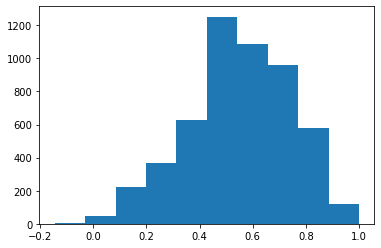

In [ ]:
print(len(correct_answer_sim_scores))
plt.hist(correct_answer_sim_scores)

7527


(array([  73.,  342.,  758., 1062., 1227., 1387., 1206.,  821.,  546.,
         105.]),
 array([-0.1381989 , -0.03213438,  0.07393013,  0.17999465,  0.28605916,
         0.39212368,  0.49818819,  0.60425271,  0.71031722,  0.81638174,
         0.92244625]),
 <a list of 10 Patch objects>)

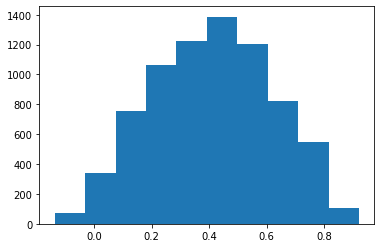

In [ ]:
# Similarity scores 
print(len(incorrect_answer_sim_scores))
plt.hist(incorrect_answer_sim_scores)

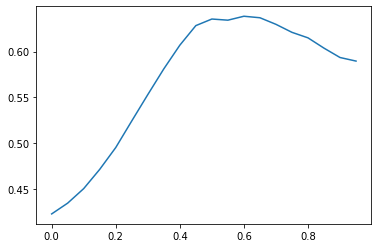

In [ ]:
#Output the pairs with their score
# for i in range(len(test_data_ref)):
#     print("{} \t\t {} \t\t Score: {:.4f}".format(test_data_ref[i], test_data_response[i], cosine_scores[i][i]))
accuracy = []
threshold = []
for i in range(0,100,5):
  threshold_num = i/100;
  result_score = []
  for i in range(len(train_data_ref)):
    if cosine_scores[i][i] >= threshold_num:
      result_score.append("correct")
    else:
      result_score.append("incorrect")

  correct_predict = 0
  for i in range(len(result_score)):
    if result_score[i] == train_data_score[i]:
      correct_predict += 1

  accuracy.append(correct_predict / len(result_score))
  threshold.append(threshold_num)

plt.plot(threshold, accuracy)

In [ ]:
max_accuracy_idx = accuracy.index(max(accuracy))
print("Threshold = " + str(threshold[max_accuracy_idx]))
print("Validation Accuracy = " + str(accuracy[max_accuracy_idx]))
best_threshold = threshold[max_accuracy_idx]

Threshold = 0.6
Validation Accuracy = 0.6385786802030456


## Testing on Testset
----

In [ ]:

#Compute embedding for both lists
embeddings1 = model.encode(test_data_ref, convert_to_tensor=True)
embeddings2 = model.encode(test_data_response, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.cos_sim(embeddings1, embeddings2)


In [ ]:
# Generate prediction & Calculate accuracy
result_score = []
for i in range(len(test_data_ref)):
    if cosine_scores[i][i] >= best_threshold:
      result_score.append("correct")
    else:
      result_score.append("incorrect")

correct_predict = 0
for i in range(len(result_score)):
  if result_score[i] == test_data_score[i]:
    correct_predict += 1

print("Testing accuracy:")
print(correct_predict / len(result_score))

Testing accuracy:
0.6739427012278308


## Conclusion

This approach is converting reference answer and student answer into sentence embeddings. Use the two sentence embeddings to calculate the cosine similarity score, and use the training set cos-sim score and labels to find the best threshold to predict "correct" or "incorrect", threshold is in the range [0,1]. After obtaining the best threshold, we use it on the test set to generate predictions using cos-sim score and threshold, and we achieved 0.6766712141882674 accuracy on the original dataset and 0.6739427012278308 on the augmented dataset. (tested on unseen-questions)